In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#HYPERPARAMETERS
n1 = 100 #it is number of neurons in first layer
n2 = 27 #number of output class (but it is kind of obvious so not sure if it is needed to make it hyperparameter

In [4]:
words = open('names.txt', 'r').read().splitlines()


In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
#-----this is just rough

In [51]:
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [53]:
W2 = torch.randn((h.shape[1], n2)) #here n2 is 27
b2 = torch.randn(n2)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [55]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [56]:
counts  = logits.exp()
prob = counts/counts.sum(1, keepdims=True)

In [65]:
loss = -(prob[torch.arange(32), Y]).log().mean()


In [89]:
#--------------now made more respectable :) -------

In [17]:
# X = []
# Y = []
# block_size = 3
# for w in words:
#     context = [0]*block_size
#     #print(w)
#     for ch in w + '.':
#         ix = stoi[ch]
#         X.append(context)
#         Y.append(ix)
#         #print(''.join([itos[i] for i in context]), '--->',ch)
#         context = context[1:] + [ix]
# X = torch.tensor(X)
# Y = torch.tensor(Y)


In [11]:
# X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [26]:
#splitting the dataset into train development/validation and test set 80:10:10
def build_dataset(words):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0]*block_size
        #print(w)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join([itos[i] for i in context]), '--->',ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [30]:
#HYPERPARAMETERS
NUM_OF_CLASS = 27
EMBEDDING_DIM = 2
NEURONSL1 = 100
WINDOW_SIZE = 3
LR = 0.1

In [31]:

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((NUM_OF_CLASS, EMBEDDING_DIM), generator=g)
W1 = torch.randn((EMBEDDING_DIM*WINDOW_SIZE, NEURONSL1), generator=g)
b1 = torch.randn(NEURONSL1, generator=g)
W2 = torch.randn((NEURONSL1, NUM_OF_CLASS), generator=g)
b2 = torch.randn(NUM_OF_CLASS, generator=g)
parameters = [C, W1, b1, W2, b2]

In [32]:
sum(p.nelement() for p in parameters)

3481

In [33]:
for p in parameters:
    p.requires_grad = True

In [34]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [46]:
for _ in range(3000):
    #-----constructing minibatch
    ix = torch.randint(0,Xtr.shape[0], (32,))
    
    #----forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, EMBEDDING_DIM*WINDOW_SIZE) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    #-----backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #-----update parameters
    for p in parameters:
        p.data += -LR*p.grad
print(loss.item())

2.4930410385131836


In [47]:
#--dev loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, EMBEDDING_DIM*WINDOW_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5471, grad_fn=<NllLossBackward0>)

In [48]:
#--test set
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, EMBEDDING_DIM*WINDOW_SIZE) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.5463, grad_fn=<NllLossBackward0>)

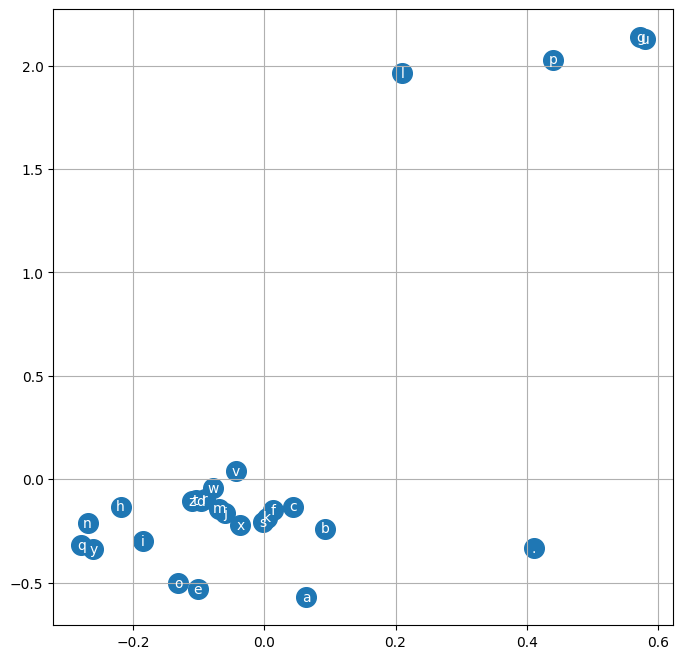

In [49]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [55]:
for _ in range(10):
    out = []
    context = [0]*WINDOW_SIZE
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

malhe.
cokiyotsilai.
ndte.
jse.
tat.
bare.
bvairti.
kplssgznasit.
shat.
tarh.
